In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from typing import Any, Dict, Tuple, Union
from PIL import Image

In [2]:
filename = "../../data/test_data.hdf5"

with h5py.File(filename, "r") as f:

    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array
    # ra = f['ra'][()]
    # dec = f['dec'][()]
    angles = f['angles'][()]
    z = f['redshifts'][()]
    label = f['labels'][()]
    images = f['images'][()]

Keys: <KeysViewHDF5 ['angles', 'images', 'labels', 'redshifts']>


In [3]:
def add_poisson_noise(image: np.array, snr: float):
    """
    Adds Poisson noise to an image with a specified intensity.

    Args:
        image (numpy.ndarray): The input image is a 256 x 256 x 3 numpy array.
        snr (float): Normalized snr value (between 0 and 1)

    Returns:
        numpy.ndarray: The noisy image as a 256 x 256 x 3 numpy array.
    """
    
    if (snr > 1) or (snr < 0):
        raise ValueError('Unphysical SNR value. Specify 0 < snr < 1')
    
    signal_level = np.mean(image)
    noise_level = signal_level / snr  - signal_level
    noise = np.random.poisson(lam=noise_level, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    
    return noisy_image

In [4]:
snrs = []
sigmas = []
for i in range(0, len(images)):
    snrs.append(np.mean(images[i]))
    
print(f'Mean SNR of total galaxy dataset: {np.mean(snrs):.3f}')
print(f'1 STD of mean SNR of total galaxy dataset: {np.std(snrs):.3f}')

Mean SNR of total galaxy dataset: 37.266
1 STD of mean SNR of total galaxy dataset: 6.668


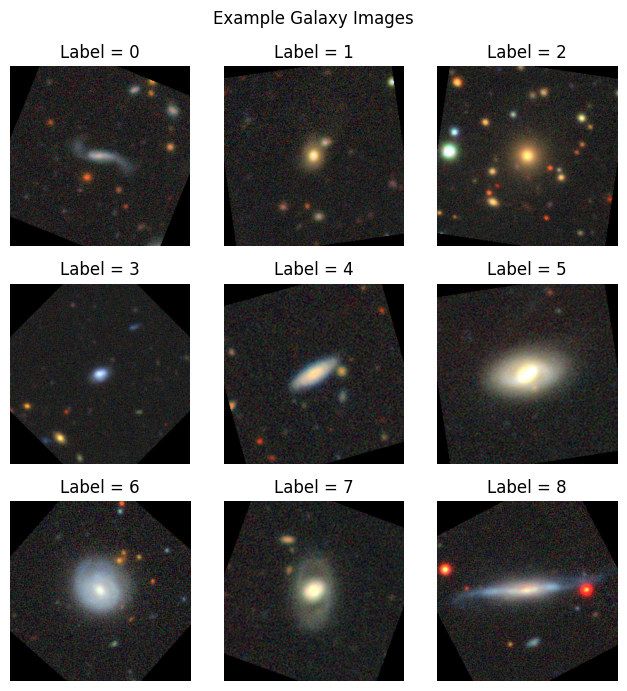

In [5]:
fig = plt.figure(figsize=(7,7))
for i in range(3*3):
    fig.suptitle('Example Galaxy Images')
    ax = fig.add_subplot(3,3, i+1)
    ax.axis('off')
    idx = np.where(label == i)[0][1]
    plt.imshow(images[idx])
    plt.grid(None)
    plt.tight_layout()
    plt.title(f'Label = {label[idx]}')

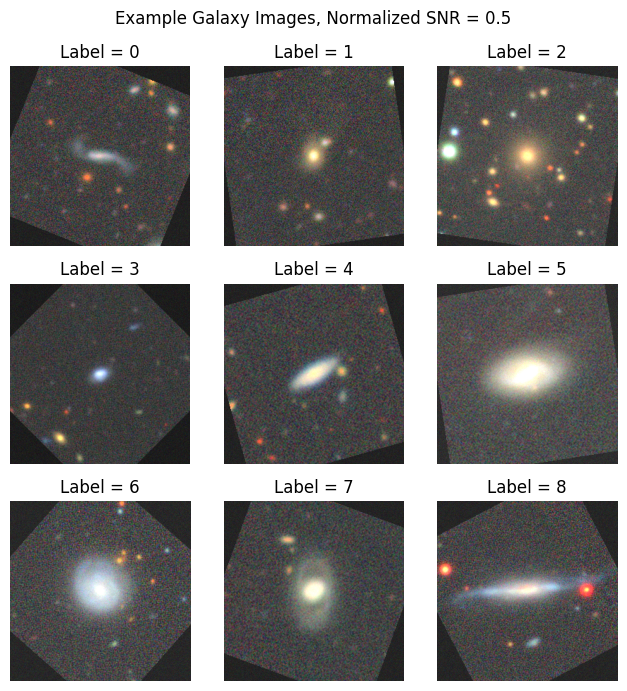

In [6]:
desired_snr = .5
fig = plt.figure(figsize=(7,7))
for i in range(3*3):
    fig.suptitle(f'Example Galaxy Images, Normalized SNR = {desired_snr}')
    ax = fig.add_subplot(3,3, i+1)
    ax.axis('off')
    idx = np.where(label == i)[0][1]
    plt.imshow(add_poisson_noise(images[idx], desired_snr))
    plt.grid(None)
    plt.tight_layout()
    plt.title(f'Label = {label[idx]}')
    # plt.savefig('../../plots/noise_galaxies.png')

We can see the addition of Poisson noise significantly reduces the quality of galaxy images.

In [7]:
for i in range(10):
    val = np.linalg.norm(add_poisson_noise(images[i], 1) - images[i])
    print(val)
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


And as a sanity check, a SNR of 1 produces the original image, as the Euclidean distance is 0.

In [8]:
def save_in_h5py_with_angles(f, images ,labels, angles, redshifts):
    dataset = f.create_dataset(
        "images", np.shape(images), data=images, compression='gzip', chunks=True)
    labels = f.create_dataset(
        "labels", np.shape(labels), data=labels,  compression='gzip', chunks=True)
    angles = f.create_dataset(
        "angles", np.shape(angles), data=angles,  compression='gzip', chunks=True)
    redshifts = f.create_dataset(
        "redshifts", np.shape(z), data=z,  compression='gzip', chunks=True)

In [9]:
snr_75 = add_poisson_noise(images, 0.75)
snr_50 = add_poisson_noise(images, 0.50)
snr_25 = add_poisson_noise(images, 0.25)

In [12]:
f = h5py.File(f'../../data/test_data_75.hdf5','w')
save_in_h5py_with_angles(f, snr_75, label, angles, z)
f.close()